# `MultiModel` framework

Here we showcase the `MultiModel` framework, a standalone framework within `neurolib` to create and simulate heterogeneous brain models. By heterogeneous, we mean that a brain network may consist of nodes with totally different dynamics coupled by a single variable. Imagine having a population model for the thalamus, a different model for the hippocampus, and a different model for the cortex. Of course, the parameters and the model dynamics, and the equations would be completely different. This is all possible and even relatively easy in `MultiModel`.

## Implemented models
To facilitate your heterogeneous experiments, the `MultiModel` comes with few population models predefined for you. We can mix these into a brain network in many ways. We provide:

* `aln`: the adaptive linear-nonlinear population model, it is a mean-field approximation of delay-coupled network of excitatory and inhibitory adaptive exponential integrate-and-fire neurons (AdEx)
* `fitzhugh_nagumo`: the FitzHugh-Nagumo model, a two-dimensional slow-fast system, is a simplified version of the famous 4D Hodgkin–Huxley model
* `hopf`: the Hopf model (sometimes called a Stuart-Landau oscillator) is a 1D nonlinear model and serves as a normal form of Hopf bifurcation in dynamical systems
* `thalamus`: a conductance-based population rate model of the thalamus, it is a Jansen-Rit like population model with current-based voltage evolution, includes adaptation (*K*-leak), calcium, and rectifying currents
* `wilson_cowan`: the Wilson-Cowan neuronal model is a simple model of interacting interconnected neurons of excitatory and inhibitory subtypes
* `wong_wang`: a Wong-Wang model, a model approximating a biophysically-based cortical network model. Our implementation comes in two flavors:
    * original Wong-Wang model with excitatory and inhibitory subtypes
    * reduced Wong-Wang model with simpler dynamics and no EXC/INH distinction
    
Moreover, the `MultiModel` framework is built in such a way that creating and connecting new models (e.g., Jansen-Rit) is easy and intuitive. An example of how to make a brand new model implementation in `MultiModel` is provided in the following example notebook (`example-4.1-create-new-model.ipynb`).

## Modeling hierarchy
The `MultiModel` relies on the modeling hierarchy, which is typically implicit in whole-brain modeling. This hierarchy has three levels:
* `NeuralMass`: represents a single neural population (typically excitatory, inhibitory, or without a subtype) and is defined by a set of parameters and (possibly delayed) (possibly stochastic) differential equations
* `Node`: represents a single brain node, and it is a set of connected neural masses (so, e.g., a single Wilson-Cowan node consists of one excitatory and one inhibitory Wilson-Cowan `NeuralMass`)
* `Network`: represents a brain network, and it is a set of connected nodes (can be any type, as long as the coupling variables are the same)

Although the magic happens at the level of `NeuralMass` (by magic, we mean the dynamics), users can only simulate (integrate) a `Node` or a `Network`. In other words, even for models without excitatory/inhibitory subtyping (e.g., Hopf or FitzHugh-Nagumo), we create a `Node` consisting of one `NeuralMass`. In the case of, e.g., Wilson-Cowan, ALN, or original Wong-Wang model, the `Node` consists of one excitatory and one inhibitory mass. More info on the modeling hierarchy and how it actually works is provided in the following example notebook (`example-4.1-create-new-model.ipynb`), where we need to subclass the base classes for this hierarchy to build a new model.

## Basic usage in `neurolib`
(In the following we expect the reader to be mildly familiar with how `neurolib` works, e.g. how to run a model, how to change it parameters, and how to get model results)

In [1]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')

# import stuff

# try:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import neurolib.utils.functions as func


from neurolib.models.multimodel import WilsonCowanNetwork, WilsonCowanNode, MultiModel

# except ImportError:
#     import sys
#     !{sys.executable} -m pip install matplotlib
#     import matplotlib.pyplot as plt

## Simulating the node

/Users/pamirozsuna/opt/anaconda3/lib/python3.7/site-packages/jitcdde/_jitcdde.py:1492: UserWarning: Your input past does not begin at t=0 but at t=1.0. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")
  0%|          | 0/2000 [00:00<?, ?it/s]/Users/pamirozsuna/opt/anaconda3/lib/python3.7/site-packages/jitcdde/_jitcdde.py:792: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than th

Using default integration parameters.



/Users/pamirozsuna/opt/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 10000 is greater than input length  = 2000, using nperseg = 2000
  .format(nperseg, input_length))


Text(0, 0.5, 'Power')

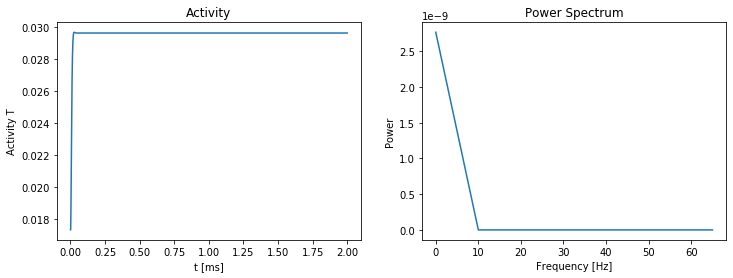

In [2]:
# create a model and wrap it to `MultiModel`
wc = MultiModel.init_node(WilsonCowanNode())

wc.params["duration"] = 2.0 * 1000  # in ms
wc.params['*EXC*ext_drive'] = 0.45
wc.params['node_exc_inh'] = 10.333333333333334
wc.params['node_inh_exc'] = 9.666666666666666
wc.params['node_inh_inh'] = 0
wc.params['network_exc_exc'] = 1.843
wc.params['network_inh_exc'] = 1.843
wc.params['sigma_ou'] = 4.2819e-05

# MultiModel offers two integration backends, be default we are using so-called `jitcdde` backend
# `jitcdde` is a numerical backend employing adaptive dt scheme for DDEs, therefore we do not care about
# actual dt (since it is adaptive), only about the sampling dt and this can be higher
# more about this in example-4.2
wc.params["sampling_dt"] = 1.0  # in ms
# run
wc.run()

exc_tc = wc.outputs["q_mean_EXC"][0,:]
frs, powers = func.getPowerSpectrum(
    exc_tc,
    wc.params["dt"],
)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(wc.t, wc["q_mean_EXC"].T)
axs[0].set_title("Activity")
axs[0].set_xlabel("t [ms]")
axs[0].set_ylabel("Activity T")
axs[1].plot(frs, powers)
axs[1].set_title("Power Spectrum")
axs[1].set_xlabel("Frequency [Hz]")
axs[1].set_ylabel("Power")

#plt.savefig('tmpagain.png', dpi=500)

As you saw in the previous cell, the internal workings of `MultiModel` are very similar to the core `neurolib`. Therefore, for simple runs, you do care about the following:
* `MultiModel`: a wrapper class for all models in MultiModel framework which gives model objects `neurolib` powers (meaning `.params` and `.run()`). `MultiModel` class is initialized as follows:
    * when initialising with `Node`: `model = MultiModel.init_node(<init'd Node class>)`
    * when initialising with `Network`: `model = MultiModel(<init'd Network class>)` (see later)
    
## `MultiModel` parameters and other accessible attributes
Since `MultiModel` is able to simulate heterogeneous models, the internals of how parameters work is a bit more complex than in the core `neurolib`. Each mass has its own parameters, each node then gathers the parameters of each mass within that node, and finally, the network gathers all parameters from each node in the network, etc. So hierarchy again. To make it easier to navigate through `MultiModel` hierarchies, some attributes are implemented in all hierarchy levels.

In [3]:
dummy_sc = np.array([[0.0, 1.0], [1.0, 0.0]])
# init MultiModelnetwork with 2 WC nodes with dummy sc and no delays

mm_net = WilsonCowanNetwork(connectivity_matrix=dummy_sc, delay_matrix=None)

print(mm_net)
# each network is an proper python iterator, i.e. len() is defined
print(f"Nodes: {len(mm_net)}")
# as well as __get_item__
print(mm_net[0])
print(mm_net[1])
# similarly, each node is a python iterator, i.e.
print(f"Masses in 1. node: {len(mm_net[0])}")
print(mm_net[0][0])
print(mm_net[0][1])

# in order to navigate through the hierarchy, each mass, node and net
# has its own name and label and index
# index of a node is relative within the network
# index of a mass is relative within the node
print(f"This network name: {mm_net.name}")
print(f"This network label: {mm_net.label}")
print(f"1st node name: {mm_net[0].name}")
print(f"1st node label: {mm_net[0].label}")
print(f"1st node index: {mm_net[0].index}")
print(f"1st mass in 1st node name: {mm_net[0][0].name}")
print(f"1st mass in 1st node label: {mm_net[0][0].label}")
print(f"1st mass in 1st node index: {mm_net[0][0].index}")

# you can also check number of variables etc at all levels of hierarchy
print(f"WC EXC num. vars: {mm_net[0][0].num_state_variables}")
print(f"WC INH num. vars: {mm_net[0][1].num_state_variables}")
print(f"WC node num. vars: {mm_net[0].num_state_variables}")
print(f"This network num. vars: {mm_net.num_state_variables}")
# similarly you can check number of "noise variables", i.e. the number
# of stochastic variables entering the simulation
print(f"WC EXC noise vars: {mm_net[0][0].num_noise_variables}")
# etc

# not sure what are the state variables? no problem!
print(f"WC EXC state vars: {mm_net[0][0].state_variable_names}")
print(f"WC node state vars: {mm_net[0].state_variable_names}")
print(f"This network state vars: {mm_net.state_variable_names}")

# if you are unsure what kind of a monster you build in MultiModel,
# a function `describe()` is available at all three levels -
# it returns a dictionary with basic info about the model object
# this is describe of a `NeuralMass`
print("")
print("Mass `describe`:")
display(mm_net[0][0].describe())
# describe of a `Node` recursively describes all masses and some more
print("")
print("Node `describe`:")
display(mm_net[0].describe())
# and finally, describe of a `Network` gives you everything
print("")
print("Network `describe`:")
display(mm_net.describe())

# PRO tip: imagine highly heterogeneous network and some long simulation with it;
# apart from the results you can dump `net.describe()` dictionary into json and
# never forget what you've done!

Brain network Wilson-Cowan network with 2 nodes
Nodes: 2
Network node: Wilson-Cowan node with 2 neural masses: Wilson-Cowan excitatory mass EXC, Wilson-Cowan inhibitory mass INH
Network node: Wilson-Cowan node with 2 neural masses: Wilson-Cowan excitatory mass EXC, Wilson-Cowan inhibitory mass INH
Masses in 1. node: 2
Neural mass: Wilson-Cowan excitatory mass with 1 state variables: q_mean_EXC
Neural mass: Wilson-Cowan inhibitory mass with 1 state variables: q_mean_INH
This network name: Wilson-Cowan network
This network label: WCnet
1st node name: Wilson-Cowan node
1st node label: WCnode
1st node index: 0
1st mass in 1st node name: Wilson-Cowan excitatory mass
1st mass in 1st node label: WCmassEXC
1st mass in 1st node index: 0
WC EXC num. vars: 1
WC INH num. vars: 1
WC node num. vars: 2
This network num. vars: 4
WC EXC noise vars: 1
WC EXC state vars: ['q_mean_EXC']
WC node state vars: [['q_mean_EXC', 'q_mean_INH']]
This network state vars: [['q_mean_EXC', 'q_mean_INH'], ['q_mean_EXC'

{'index': 0,
 'name': 'Wilson-Cowan excitatory mass',
 'mass_type': 'EXC',
 'num_state_variables': 1,
 'num_noise_variables': 1,
 'state_variable_names': ['q_mean_EXC'],
 'params': {'a': 1.5,
  'mu': 3.0,
  'tau': 2.5,
  'ext_drive': 0.0,
  'input_0': {'type': 'OrnsteinUhlenbeckProcess',
   'mu': 0.0,
   'sigma': 0.0,
   'tau': 5.0,
   'n': 1,
   'seed': None}}}


Node `describe`:


{'index': 0,
 'name': 'Wilson-Cowan node',
 'num_masses': 2,
 'num_num_state_variables': 2,
 'num_noise_variables': 2,
 'masses': [{'index': 0,
   'name': 'Wilson-Cowan excitatory mass',
   'mass_type': 'EXC',
   'num_state_variables': 1,
   'num_noise_variables': 1,
   'state_variable_names': ['q_mean_EXC'],
   'params': {'a': 1.5,
    'mu': 3.0,
    'tau': 2.5,
    'ext_drive': 0.0,
    'input_0': {'type': 'OrnsteinUhlenbeckProcess',
     'mu': 0.0,
     'sigma': 0.0,
     'tau': 5.0,
     'n': 1,
     'seed': None}}},
  {'index': 1,
   'name': 'Wilson-Cowan inhibitory mass',
   'mass_type': 'INH',
   'num_state_variables': 1,
   'num_noise_variables': 1,
   'state_variable_names': ['q_mean_INH'],
   'params': {'a': 1.5,
    'mu': 3.0,
    'tau': 3.75,
    'ext_drive': 0.0,
    'input_0': {'type': 'OrnsteinUhlenbeckProcess',
     'mu': 0.0,
     'sigma': 0.0,
     'tau': 5.0,
     'n': 1,
     'seed': None}}}],
 'local_connectivity': array([[16., 12.],
        [15.,  3.]]),
 'local_d


Network `describe`:


{'name': 'Wilson-Cowan network',
 'num_nodes': 2,
 'num_state_variables': 4,
 'num_noise_variables': 4,
 'nodes': [{'index': 0,
   'name': 'Wilson-Cowan node',
   'num_masses': 2,
   'num_num_state_variables': 2,
   'num_noise_variables': 2,
   'masses': [{'index': 0,
     'name': 'Wilson-Cowan excitatory mass',
     'mass_type': 'EXC',
     'num_state_variables': 1,
     'num_noise_variables': 1,
     'state_variable_names': ['q_mean_EXC'],
     'params': {'a': 1.5,
      'mu': 3.0,
      'tau': 2.5,
      'ext_drive': 0.0,
      'input_0': {'type': 'OrnsteinUhlenbeckProcess',
       'mu': 0.0,
       'sigma': 0.0,
       'tau': 5.0,
       'n': 1,
       'seed': None}}},
    {'index': 1,
     'name': 'Wilson-Cowan inhibitory mass',
     'mass_type': 'INH',
     'num_state_variables': 1,
     'num_noise_variables': 1,
     'state_variable_names': ['q_mean_INH'],
     'params': {'a': 1.5,
      'mu': 3.0,
      'tau': 3.75,
      'ext_drive': 0.0,
      'input_0': {'type': 'OrnsteinUhl

In [4]:
# now let us check the parameters.. for this we initialise MultiModel in neurolib's fashion
#aln_net = MultiModel(mm_net)
wc_net = MultiModel(mm_net)
# parameters are accessible via .params
#aln_net.params
wc_net.params
# as you can see the parameters are flattened nested dictionary which follows this nomenclature
# {"<network label>.<node label>_index.<mass label>_index.<param name>: param value"}

{'WCnet.WCnode_0.WCmassEXC_0.a': 1.5,
 'WCnet.WCnode_0.WCmassEXC_0.mu': 3.0,
 'WCnet.WCnode_0.WCmassEXC_0.tau': 2.5,
 'WCnet.WCnode_0.WCmassEXC_0.ext_drive': 0.0,
 'WCnet.WCnode_0.WCmassEXC_0.input_0.type': 'OrnsteinUhlenbeckProcess',
 'WCnet.WCnode_0.WCmassEXC_0.input_0.mu': 0.0,
 'WCnet.WCnode_0.WCmassEXC_0.input_0.sigma': 0.0,
 'WCnet.WCnode_0.WCmassEXC_0.input_0.tau': 5.0,
 'WCnet.WCnode_0.WCmassEXC_0.input_0.n': 1,
 'WCnet.WCnode_0.WCmassEXC_0.input_0.seed': None,
 'WCnet.WCnode_0.WCmassINH_1.a': 1.5,
 'WCnet.WCnode_0.WCmassINH_1.mu': 3.0,
 'WCnet.WCnode_0.WCmassINH_1.tau': 3.75,
 'WCnet.WCnode_0.WCmassINH_1.ext_drive': 0.0,
 'WCnet.WCnode_0.WCmassINH_1.input_0.type': 'OrnsteinUhlenbeckProcess',
 'WCnet.WCnode_0.WCmassINH_1.input_0.mu': 0.0,
 'WCnet.WCnode_0.WCmassINH_1.input_0.sigma': 0.0,
 'WCnet.WCnode_0.WCmassINH_1.input_0.tau': 5.0,
 'WCnet.WCnode_0.WCmassINH_1.input_0.n': 1,
 'WCnet.WCnode_0.WCmassINH_1.input_0.seed': None,
 'WCnet.WCnode_0.local_connectivity': array([[16., 

In [5]:
# as you can see there are a lot of parameters for simple 2-node network of ALN models
# typically you want to change parameters of all nodes at the same time
# fortunately, model.params is not your basic dictionary, it's a special one, we call it `star` dictionary,
# because you can do this:
display(wc_net.params["*tau"])
print("")

# so yes, star works as a glob identifier, so by selecting "*tau" I want all parameters named tau
# (I dont care from which mass or node it comes)
# what if I want to change taus only in EXC masses? easy:
#display(aln_net.params["*EXC*tau"])
display(wc_net.params["*EXC*tau"])
print("")
# or maybe I want to change taus only in the first node?
display(wc_net.params["*Node_0*tau"])
display(wc_net.params["*Node_0*tau"])
print("")
# of course, you can change a param value with this
wc_net.params["*Node_0*tau"] = 13.2
display(wc_net.params["*Node_0*tau"])
wc_net.params["*Node_0*tau"] = 5.0

{'WCnet.WCnode_0.WCmassEXC_0.tau': 2.5,
 'WCnet.WCnode_0.WCmassEXC_0.input_0.tau': 5.0,
 'WCnet.WCnode_0.WCmassINH_1.tau': 3.75,
 'WCnet.WCnode_0.WCmassINH_1.input_0.tau': 5.0,
 'WCnet.WCnode_1.WCmassEXC_0.tau': 2.5,
 'WCnet.WCnode_1.WCmassEXC_0.input_0.tau': 5.0,
 'WCnet.WCnode_1.WCmassINH_1.tau': 3.75,
 'WCnet.WCnode_1.WCmassINH_1.input_0.tau': 5.0}

{'WCnet.WCnode_0.WCmassEXC_0.tau': 2.5,
 'WCnet.WCnode_0.WCmassEXC_0.input_0.tau': 5.0,
 'WCnet.WCnode_1.WCmassEXC_0.tau': 2.5,
 'WCnet.WCnode_1.WCmassEXC_0.input_0.tau': 5.0}

{}

{}

{}

In [6]:
# case: I want to change all taus except "noise" taus
# this gives all the taus, including "noise"
display(wc_net.params["*tau*"])
print("")
# pipe symbol filters out unwanted keys - here we have only taus which key does NOT include "input"
display(wc_net.params["*tau*|input"])

{'WCnet.WCnode_0.WCmassEXC_0.tau': 2.5,
 'WCnet.WCnode_0.WCmassEXC_0.input_0.tau': 5.0,
 'WCnet.WCnode_0.WCmassINH_1.tau': 3.75,
 'WCnet.WCnode_0.WCmassINH_1.input_0.tau': 5.0,
 'WCnet.WCnode_1.WCmassEXC_0.tau': 2.5,
 'WCnet.WCnode_1.WCmassEXC_0.input_0.tau': 5.0,
 'WCnet.WCnode_1.WCmassINH_1.tau': 3.75,
 'WCnet.WCnode_1.WCmassINH_1.input_0.tau': 5.0}

{'WCnet.WCnode_0.WCmassEXC_0.tau': 2.5,
 'WCnet.WCnode_0.WCmassINH_1.tau': 3.75,
 'WCnet.WCnode_1.WCmassEXC_0.tau': 2.5,
 'WCnet.WCnode_1.WCmassINH_1.tau': 3.75}

In [14]:
max_rate_e = []
min_rate_e = []

# number low for testing:
exc_inputs = np.linspace(0, 3.5, 2)
# use: exc_inputs = np.linspace(0, 3.5, 20)

# the 1D bif. diagram
wc.params["duration"] = 2.0 * 1000 
wc.params['node_exc_inh'] = 10.333333333333334
wc.params['node_inh_exc'] = 9.666666666666666
wc.params['node_inh_inh'] = 0
wc.params['network_exc_exc'] = 1.843
wc.params['network_inh_exc'] = 1.843
wc.params['sigma_ou'] = 4.2819e-05
wc.params["sampling_dt"] = 1.0  # in ms
for exc_ext in exc_inputs:
    wc.params["*EXC*ext_drive"] = exc_ext
    wc.run()
    max_rate_e.append(np.max(wc.output[0, -int(1000 / wc.params["sampling_dt"]) :]))
    min_rate_e.append(np.min(wc.output[0, -int(1000 / wc.params["sampling_dt"]) :]))

100%|██████████| 2000/2000 [00:00<00:00, 189226.68it/s]

Using default integration parameters.



100%|██████████| 2000/2000 [00:00<00:00, 199881.05it/s]

Using default integration parameters.



100%|██████████| 2000/2000 [00:00<00:00, 165152.84it/s]

Using default integration parameters.


Using default integration parameters.


100%|██████████| 2000/2000 [00:00<00:00, 42087.40it/s]

Using default integration parameters.



100%|██████████| 2000/2000 [00:00<00:00, 56668.68it/s]

Using default integration parameters.



100%|██████████| 2000/2000 [00:00<00:00, 64077.73it/s]

Using default integration parameters.



100%|██████████| 2000/2000 [00:00<00:00, 179642.97it/s]

Using default integration parameters.



100%|██████████| 2000/2000 [00:00<00:00, 30443.25it/s]

Using default integration parameters.



100%|██████████| 2000/2000 [00:00<00:00, 172038.72it/s]

Using default integration parameters.


Text(0, 0.5, 'Min / max firing rate [kHz]')

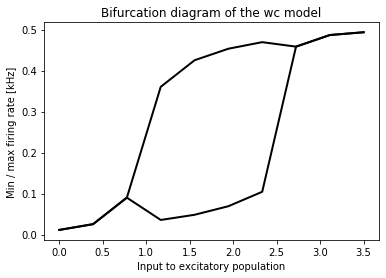

In [15]:
plt.plot(exc_inputs, max_rate_e, c="k", lw=2)
plt.plot(exc_inputs, min_rate_e, c="k", lw=2)
plt.title("Bifurcation diagram of the wc model")
plt.xlabel("Input to excitatory population")
plt.ylabel("Min / max firing rate [kHz]")